## Inteligência Artificial 2024.1 : Prova N1 - 1o Bimestre 

### Nome: Carlos Eduardo Vieira Santos

### RA: 081200016

In [302]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import seaborn as sns
import numpy as np

sns.set_theme(rc={"figure.figsize": (12, 6)})

## Base de dados :

In [303]:
base = pd.read_excel('Base_N1_B1_2024.1.xlsx')
base.head()

,Feature1,Feature2,Label
0,0.000,5.472986,Red
1,0.005,4.326074,Red
2,0.010,5.257439,Red
3,0.015,3.321764,Red
4,0.020,5.783143,Red


In [304]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  800 non-null    float64
 1   Feature2  800 non-null    float64
 2   Label     800 non-null    object 
dtypes: float64(2), object(1)
memory usage: 18.9+ KB


In [305]:
base.describe()

,Feature1,Feature2
count,800.000000,800.000000
mean,1.072500,3.588866
std,0.582564,3.133176
min,0.000000,-3.353179
25%,0.573750,0.712466
50%,1.072500,3.553948
75%,1.571250,6.438598
max,2.145000,9.963324


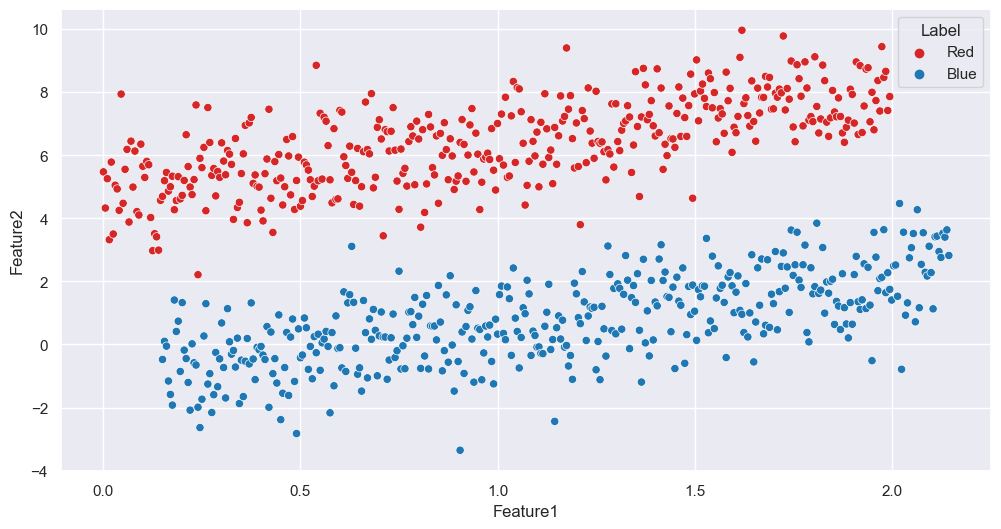

In [306]:
sns.scatterplot(
    base, x="Feature1", y="Feature2", hue="Label", palette=["tab:red", "tab:blue"]
)
plt.show()

In [307]:
random_state = 42 # variável definida arbitariamente para que os resultados sejam replicáveis

## Desenvolvimento do classificador :

#### Variáveis auxiliares

In [308]:
labels_to_values = {"Red": 0, "Blue": 1}
values_to_labels = {v: k for k, v in labels_to_values.items()}

#### Separa variáveis X e Y

In [309]:
X = base[["Feature1", "Feature2"]].values
y = base["Label"].map(labels_to_values).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

#### Inicializa classificador por regressão logística

In [310]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_predicted = classifier.predict(X_test)
y_probabilities = classifier.predict_proba(X_test)

In [311]:
# dataframes para visualização

df_train = pd.DataFrame(X_train, columns=["Feature1", "Feature2"])
df_train["Expected"] = y_train
df_train["Label"] = df_train["Expected"].map(values_to_labels)
df_train["TrainOrTest"] = "train"

df_test = pd.DataFrame(X_test, columns=["Feature1", "Feature2"])
df_test["Expected"] = y_test
df_test["Predicted"] = y_predicted
df_test["RedProbability"] = y_probabilities[:, 0]
df_test["BlueProbability"] = y_probabilities[:, 1]
df_test["Probability"] = df_test["RedProbability"].where(
    df_test["Predicted"] == 0, df_test["BlueProbability"]
)
df_test["Label"] = df_test["Expected"].map(values_to_labels)
df_test["TrainOrTest"] = "test"

df = pd.concat([df_train, df_test], ignore_index=False)

#### Plota decision boundary

In [312]:
# extrai os pesos
w0 = classifier.intercept_[0]
w1, w2 = map(lambda x: x[0], classifier.coef_.T)

w0, w1, w2

(6.550824648739458, 2.7793841104264967, -2.6501589788271094)

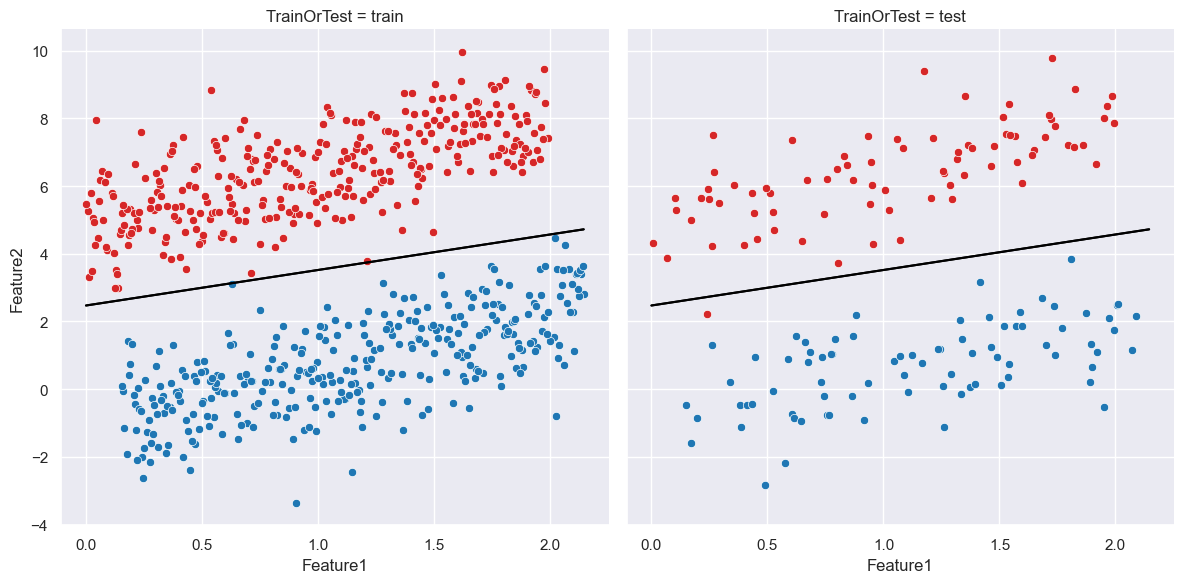

In [313]:
x_values = np.linspace(base["Feature1"].min(), base["Feature1"].max(), 100)
y_values = -(w0 + w1 * x_values) / w2

grid = sns.FacetGrid(
    df, col="TrainOrTest", hue="Label", palette=["tab:red", "tab:blue"], height=6
)
grid.map(sns.scatterplot, "Feature1", "Feature2")
grid.map_dataframe(lambda *args, **kwargs: plt.plot(x_values, y_values, color="black"))
plt.show()

#### Calcula métricas para aferir a qualidade do classificador

Métricas principais de classificadores:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        80
           1       0.99      1.00      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

Distribuição da probabilidade de acerto:


(0.9, 1.0]    154
(0.8, 0.9]      4
(0.7, 0.8]      2
(0.1, 0.2]      0
(0.2, 0.3]      0
(0.3, 0.4]      0
(0.4, 0.5]      0
(0.5, 0.6]      0
(0.6, 0.7]      0
Name: Probability, dtype: int64

Distribuição da probabilidade de acerto (%):


(0.9, 1.0]    0.9625
(0.8, 0.9]    0.0250
(0.7, 0.8]    0.0125
(0.1, 0.2]    0.0000
(0.2, 0.3]    0.0000
(0.3, 0.4]    0.0000
(0.4, 0.5]    0.0000
(0.5, 0.6]    0.0000
(0.6, 0.7]    0.0000
Name: Probability, dtype: float64

Probabilidade da previsão menos provável: 0.7444115741378277
Probabilidade da previsão mais provável: 0.9999997940507395


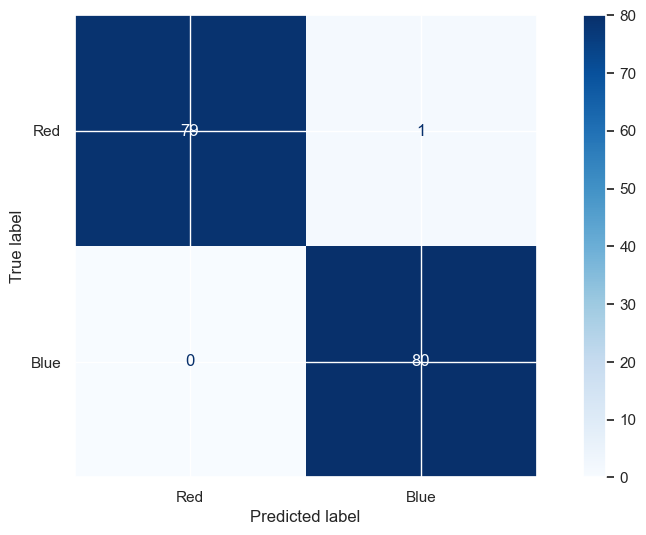

In [314]:
clf_rpt = classification_report(y_test, y_predicted)

print(f"Métricas principais de classificadores:\n\n{clf_rpt}")

print("Distribuição da probabilidade de acerto:")
display(
    pd.cut(df_test["Probability"], bins=[i / 10 for i in range(1, 11)]).value_counts()
)

print("Distribuição da probabilidade de acerto (%):")
display(
    pd.cut(df_test["Probability"], bins=[i / 10 for i in range(1, 11)]).value_counts(
        normalize=True
    )
)

print(f"Probabilidade da previsão menos provável: {df_test['Probability'].min()}")
print(f"Probabilidade da previsão mais provável: {df_test['Probability'].max()}")

ConfusionMatrixDisplay.from_estimator(
    classifier, X_test, y_test, display_labels=["Red", "Blue"], cmap=plt.cm.Blues
)

## Desenvolvimento do estimador :

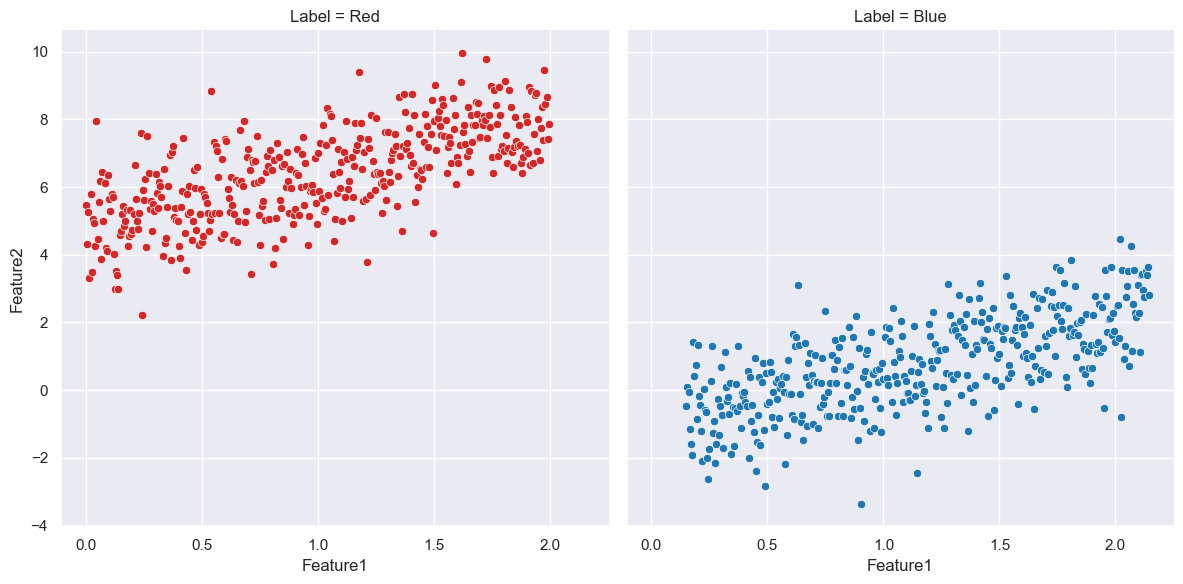

In [315]:
df_red = base.loc[base["Label"] == "Red", ["Feature1", "Feature2"]]
df_blue = base.loc[base["Label"] == "Blue", ["Feature1", "Feature2"]]

grid = sns.FacetGrid(
    base, col="Label", hue="Label", palette=["tab:red", "tab:blue"], height=6
)
grid.map(sns.scatterplot, "Feature1", "Feature2")
plt.show()

In [316]:
def create_estimator_and_tests(df, independent_var, dependent_var):
    X = df[dependent_var].values
    y = df[independent_var].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)

    estimator = LinearRegression()
    estimator.fit(X_train, y_train)

    return estimator, X_test, y_test

red_estimator, X_test_red, y_test_red = create_estimator_and_tests(df_red, "Feature1", "Feature2")
blue_estimator, X_test_blue, y_test_blue = create_estimator_and_tests(df_blue, "Feature1", "Feature2")

In [317]:
y_pred_red = red_estimator.predict(X_test_red)
y_pred_blue = blue_estimator.predict(X_test_blue)

In [318]:
def to_dataframe(label, X_test, y_test, y_pred):
    label_arr = np.ones((len(X_test_red), 1)) * label

    return pd.DataFrame(
        np.concatenate(
            [
                label_arr,
                X_test,
                y_test.reshape(-1, 1),
                y_pred.reshape(-1, 1),
            ],
            axis=1,
        ),
        columns=["Label", "Feature", "Expected", "Predicted"],
    )

df_test_red = to_dataframe(0, X_test_red, y_test_red, y_pred_red)
df_test_blue = to_dataframe(1, X_test_blue, y_test_blue, y_pred_blue)

df_test = pd.concat([df_test_red, df_test_blue], ignore_index=True)
df_test["Label"] = df_test["Label"].map(values_to_labels)

In [319]:
def display_regression_performance_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R² score: {r2}")

In [329]:
n = base.groupby(["Label"], as_index=False).agg(
    Min=("Feature2", "min"),
    Max=("Feature2", "max"),
    Mean=("Feature2", "mean")
)
n["Max"] - n["Min"]          

0    7.824262
1    7.750740
dtype: float64

Métricas das variáveis no dataset original:


,Label,Min,Max,Mean
0,Blue,-3.353179,4.471083,0.773814
1,Red,2.212583,9.963324,6.403917


Métricas de desempenho do estimador vermelho:
Mean Absolute Error: 0.3570453506215509
Mean Squared Error: 0.1985573809588179
Root Mean Squared Error: 0.44559777934682065
R² score: 0.48446135547706204


Métricas de desempenho do estimador azul:
Mean Absolute Error: 0.3631710584501966
Mean Squared Error: 0.18863939632765553
Root Mean Squared Error: 0.43432637074860597
R² score: 0.5102126235913874




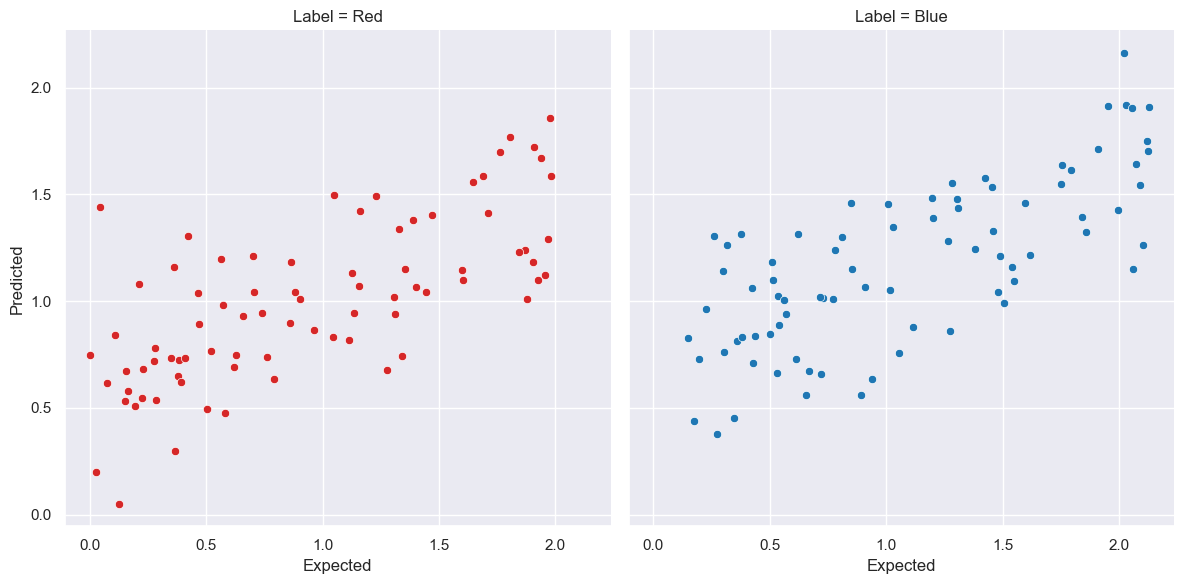

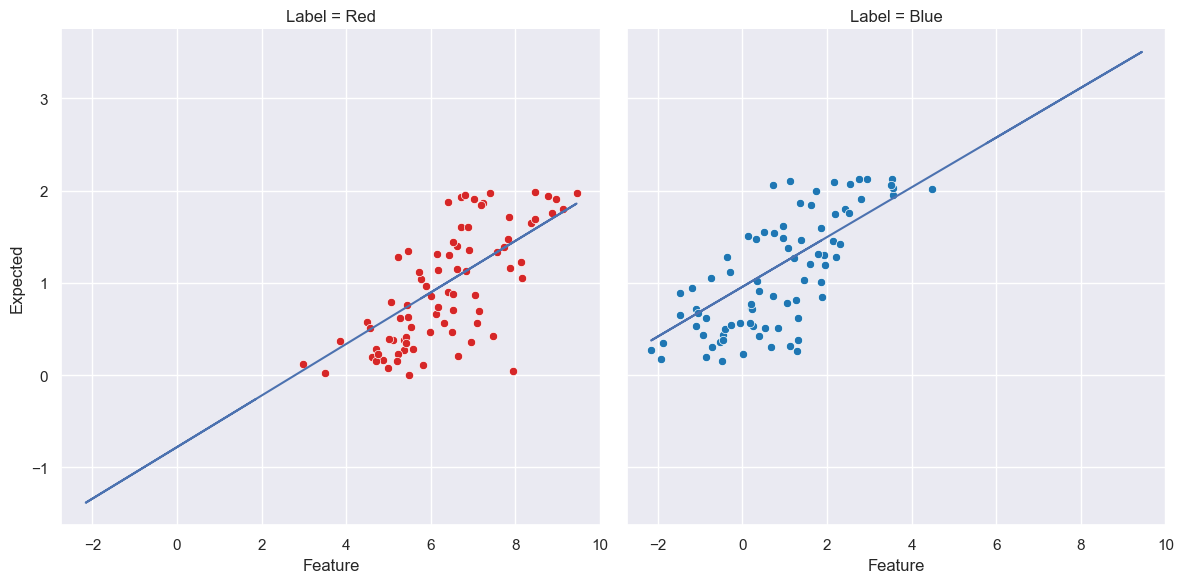

In [327]:
print("Métricas das variáveis no dataset original:")
display(base.groupby(["Label"], as_index=False).agg(
    Min=("Feature2", "min"),
    Max=("Feature2", "max"),
    Mean=("Feature2", "mean")
))

print("Métricas de desempenho do estimador vermelho:")
display_regression_performance_metrics(y_test_red, y_pred_red)
print("\n")

print("Métricas de desempenho do estimador azul:")
display_regression_performance_metrics(y_test_blue, y_pred_blue)
print("\n")

grid = sns.FacetGrid(
    df_test, col="Label", hue="Label", palette=["tab:red", "tab:blue"], height=6
)
grid.map(sns.scatterplot, "Expected", "Predicted")
plt.show()

def plot_line(data, **kwargs):
    label = data["Label"].iloc[0]
    if label == "Red":
        y_values = red_estimator.predict(df_test["Feature"].values.reshape(-1, 1))    
    if label == "Blue":
        y_values = blue_estimator.predict(df_test["Feature"].values.reshape(-1, 1))
            
    plt.plot(df_test["Feature"], y_values)

grid = sns.FacetGrid(
    df_test, col="Label", hue="Label", palette=["tab:red", "tab:blue"], height=6
)
grid.map(sns.scatterplot, "Feature", "Expected")
grid.map_dataframe(plot_line)
plt.show()

## Conclusão :

#### Classificador

Ao observar a distribuição dos pontos pertencentes a cada classe disponíveis no dataset, é possível observar um padrão linear, o que justifica o uso de um algoritmo de regressão logística para a previsão de novos valores.

Durante os testes realizados com as configurações apresentadas, o modelo chegou a uma exatidão de 99%, tendo previsto apenas 1 ponto de forma incorreta (um caso de falso azul). 

Também é possível observar a confiabilidade do modelo através do cálculo de probabilidade de cada previsão: probabilidade da previsão de menor "certeza" foi de 74,44%, enquanto que a de maior certeza foi de 99,99%. Além disso, 96,25% das previsões apresentou mais do que 90% de probabilidade.

Logo, é seguro afirmar que, caso as condições de novos dados não sejam extremamente adversas às do dataset disponibilizado para treino, o modelo tende a ter um bom desempenho durante a etapa de classificação.

#### Estimador

Foram criados dois estimadores, sendo um para cada classe presente no dataset disponibilizado (Red e Blue). Assim como na etapa de classificação, os dados também apresentam tendência linear quando separados e organizados em relação às duas características presentes no dataset. Assim, o estimador utilizado foi o algoritmo de regressão linear.

Dentre os indicadores utilizados para se analisar o desempenho de cada estimador, o erro médio absoluto (MAE, do inglês *Mean Absolute Error*) e a raíz do erro médio quadrático (RMSE, do inglês *Root Mean Squared Error*) chamaram mais atenção por estarem na mesma grandeza que os dados do dataset. Abaixo, os valores:

- Estimador vermelho:
    - MAE = 0,3570
    - RMSE = 0,4456

- Estimador azul:
    - MAE = 0,3632
    - RMSE = 0,4343

Os valores de ambos aparentam estar próximos e demonstram um desempenho não tão bom quando consideramos os intervalos dos pontos possíveis do dataset vermelho (de 2,21 a 9,96) e do azul (de -3,35 a 4,47). Para dois intervalos de tamanho próximo a 8 unidades, meia unidade pode ser bastante significativa. Logo, não se pode dizer que os estimadores são tão confiáveis quanto o classificador, por exemplo.

#### Recomendações

Por um lado, o classificador pode ser utilizado e é possível confiar em seus resultados.  
Por outro lado, o estimador apresenta uma tendência de cometer erros consideráveis. Talvez seu desempenho possa ser melhorado caso sejam adicionadas novas features ao modelo.